In [1]:
%matplotlib inline

# Introduction to Deep Learning with TensorFlow
Reference: This is based on tutorials written by Daniel Moser (UT Southwestern Medical Center), [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), and [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)

# Overview

Build two NN models for classifying handwritten numbers with accuracies surpassing 95%. 

- The first model is a basic fully-connected neural network.
- The second model is a deep convolutional neural network.

MNIST database contains 60,000 images for training and 10,000 test images.


<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

# Loading Python  Modules


In [2]:
import matplotlib.pyplot as plt  
import numpy as np                  
import tensorflow as tf


# MNIST Data

The MNIST dataset is conveniently bundled within Keras

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

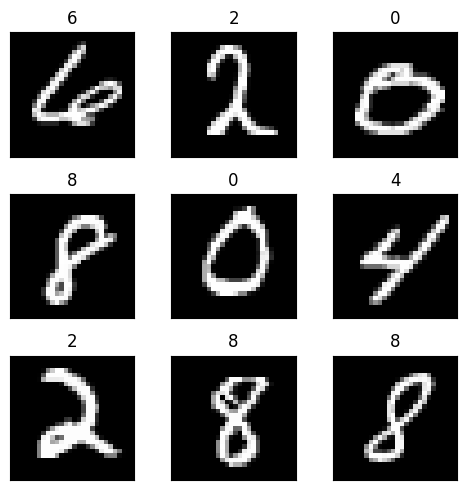

In [4]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = np.random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title(y_train[num])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

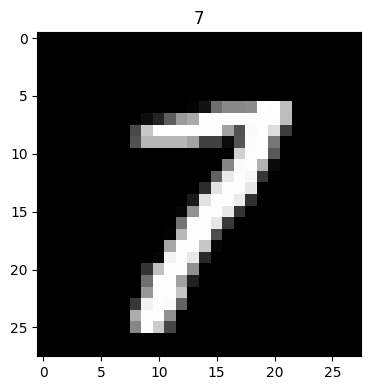


Each pixel is an 8-bit integer from 0-255.
0 is full black, while 255 is full white.

0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   3  18 110 136 136 141 255 254 189 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0  13  36  94 154 170 253 253 253 253 253 253 253 188 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  74 200 253 253 253 253 253 253 164  82 250 253 221  61 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  82 182 182 182 182 163  65  65  11  85 252 253 118   0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0   0   0   0   0   0   0   0   0   0 209 253 253

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end=" ")
        print("")

num = np.random.randint(0, len(X_train))
plt.figure(figsize=(4,4))
plt.imshow(X_train[num], cmap='gray', interpolation='none')
plt.title(y_train[num])
plt.tight_layout()
plt.show()
print("\nEach pixel is an 8-bit integer from 0-255.\n0 is full black, while 255 is full white.\n")
matprint(X_train[num])

# Model 1: fully-connected neural network (FCN)

 ## Data pre-processing

### Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 28*28 =784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255].

In [6]:
# An example
xx = np.random.randint(1,10,(3,3))
print(xx)
print('\nflatten:\n',xx.flatten())

[[8 7 4]
 [9 3 2]
 [3 3 3]]

flatten:
 [8 7 4 9 3 2 3 3 3]


In [7]:
print("Training X matrix initial shape", X_train.shape)
print("Testing X matrix initial shape", X_test.shape)

X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix initial shape (60000, 28, 28)
Testing X matrix initial shape (10000, 28, 28)
Training X matrix shape (60000, 784)
Testing X matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

### Formatting the output data layer



In [8]:
nb_classes = 10 # number of unique digits

Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_test  = tf.keras.utils.to_categorical(y_test, nb_classes)

print("Training Y matrix shape",Y_train.shape)
print("Testing Y matrix shape",Y_test.shape)

Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


## Building the model

### Approach 1

In [9]:
model = tf.keras.Sequential()

# first layer
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))

# second layer
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))

# Third/output layer
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

### Approach 2

In [10]:
# The Sequential model is a linear stack of layers and is very common.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu',input_shape=(28*28,)),
    tf.keras.layers.Dropout(0.2),
    #--------------------------------------------------
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #--------------------------------------------------
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [11]:
# Summarize the built model
model.build(input_shape=(28*28,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


## Compiling the model
When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)



In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # ,tf.keras.metrics.Precision()

## Training the model

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20) #, patience=3, baseline=0.4, min_delta=1

fit_output = model.fit(X_train, Y_train,
          batch_size=128,  # 32, 128, 10000
          epochs=3,
          validation_data=(X_test,Y_test),
          callbacks=[callback],
          verbose=1)



Epoch 1/3
469/469 [==============================] - 12s 24ms/step - loss: 0.2458 - accuracy: 0.9262 - val_loss: 0.1124 - val_accuracy: 0.9645
Epoch 2/3
469/469 [==============================] - 10s 20ms/step - loss: 0.0998 - accuracy: 0.9691 - val_loss: 0.0708 - val_accuracy: 0.9783
Epoch 3/3
469/469 [==============================] - 11s 24ms/step - loss: 0.0719 - accuracy: 0.9774 - val_loss: 0.0757 - val_accuracy: 0.9772


['loss', 'accuracy', 'val_loss', 'val_accuracy']


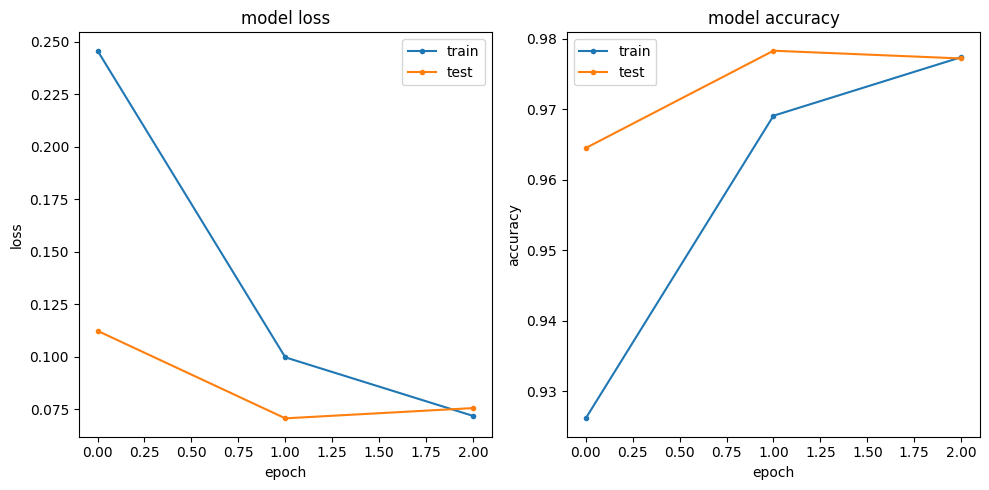

In [14]:
history = fit_output.history
# list all data in history
print(list(history.keys()))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
# summarize history for loss
plt.plot(history['loss'],'.-')
plt.plot(history['val_loss'],'.-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(1,2,2)
# summarize history for accuracy
plt.plot(history['accuracy'],'.-')
plt.plot(history['val_accuracy'],'.-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.tight_layout()
plt.show()

## Testing the model

In [15]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])
# print('Test accuracy:', score[2])

313/313 [==============================] - 1s 4ms/step - loss: 0.0757 - accuracy: 0.9772
Test score: 0.0756506621837616
Test accuracy: 0.9771999716758728


## Inspecting the predictions

It's always a good idea to inspect the output and make sure everything looks sane.

In [16]:
y_predicted = model.predict(X_test)

313/313 [==============================] - 1s 4ms/step


In [17]:
print(y_predicted.shape)
print(y_predicted[0:3,:])
print(np.argmax(y_predicted[0:3,:],axis=1))

(10000, 10)
[[4.6082695e-07 1.1797306e-06 1.4375179e-04 2.1446099e-04 5.0768012e-10
  4.6417873e-07 1.3263705e-09 9.9963689e-01 8.8643594e-07 1.8602951e-06]
 [2.2878908e-09 1.4986887e-06 9.9999815e-01 2.3040280e-07 1.8850409e-11
  4.4573852e-11 6.2248567e-11 7.1528095e-10 8.5168228e-09 6.4885808e-13]
 [2.1431363e-07 9.9669439e-01 1.7757800e-04 7.6175916e-06 4.4820781e-04
  2.2092497e-06 5.7875141e-06 2.4935806e-03 1.6703925e-04 3.3496808e-06]]
[7 2 1]


In [18]:
y_predicted = np.argmax(y_predicted,axis=1)

# Check which items we got right / wrong
correct_indices   = np.nonzero(y_predicted == y_test)[0]
incorrect_indices = np.nonzero(y_predicted != y_test)[0]


### Inspecting **correct** predictions

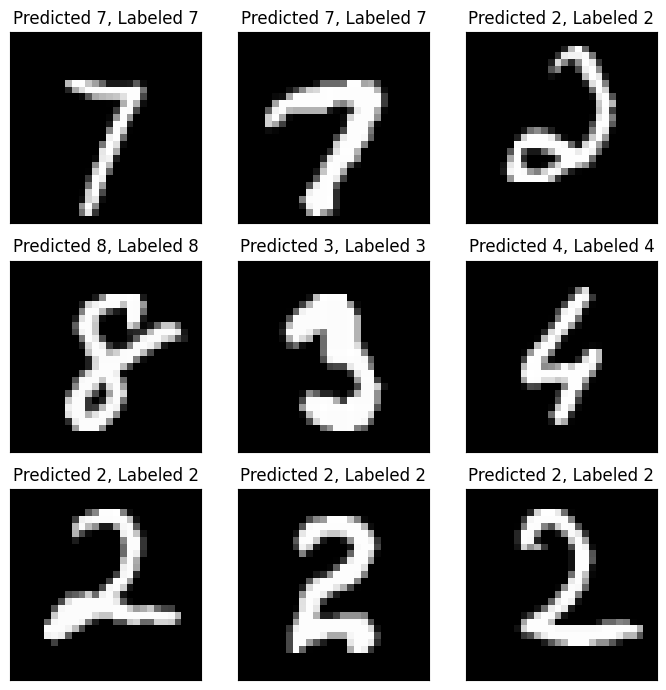

In [19]:
plt.figure(figsize=(7,7))
for i, correct in enumerate(correct_indices[np.random.randint(0,len(correct_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[correct], y_test[correct])) 
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


### Inspecting **incorrect** predictions

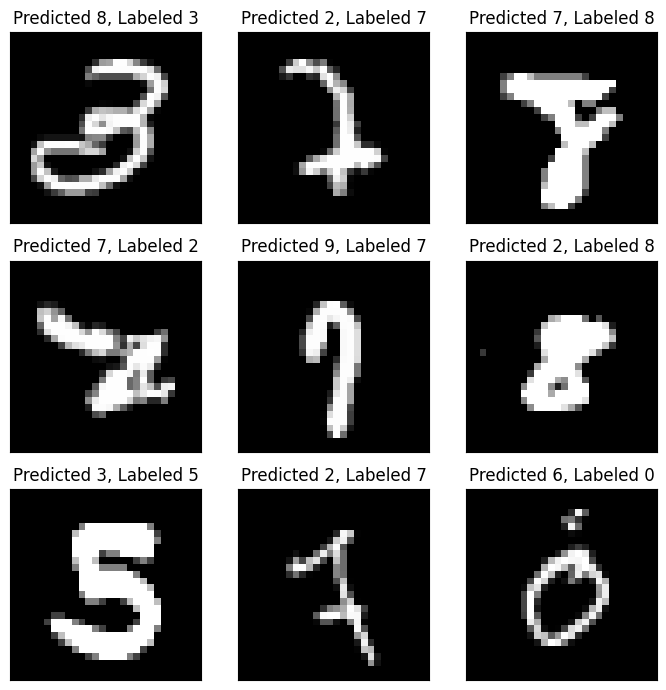

In [20]:
plt.figure(figsize=(7,7))
for i, incorrect in enumerate(incorrect_indices[np.random.randint(0,len(incorrect_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Model 2: Convolutional Neural Network

 ## Data pre-processing

### Loading data

In [21]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

### Formatting the input layer

In [22]:
print("Training X matrix initial shape", X_train.shape)
print("Testing X matrix initial shape", X_test.shape)
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix initial shape (60000, 28, 28)
Testing X matrix initial shape (10000, 28, 28)
Training X matrix shape (60000, 28, 28, 1)
Testing X matrix shape (10000, 28, 28, 1)


### Formatting the output layer

In [23]:
# one-hot format classes
nb_classes = 10 # number of unique digits
Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_test  = tf.keras.utils.to_categorical(y_test, nb_classes)

## Building the model

In [24]:
model = tf.keras.Sequential([    
    #---------------------------------------
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2), padding='valid'),
    #---------------------------------------
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #---------------------------------------
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                      

## Compiling the model

In [25]:
# use the same optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the model  (takes several minutes)

In [ ]:
model.fit(X_train, Y_train,
          batch_size=512,
          epochs=5,
          validation_data=(X_test,Y_test))


## Saving and loading a fitted model

In [28]:
import os
import pickle
from google.colab import drive
drive.mount('/content/drive') # , force_remount=True

# save the model to disk
filename = '/content/drive/MyDrive/FEM505/MNIST_CNN_model.sav'
if not os.path.exists(filename):
    print('saving...')
    with open(filename, 'wb') as _file:
        pickle.dump(model,_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# # load the model from disk
model = pickle.load(open(filename, 'rb'))

In [30]:
# score = model.evaluate(X_train, Y_train)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 18s 57ms/step - loss: 0.0269 - accuracy: 0.9917
Test loss: 0.026852604001760483
Test accuracy: 0.9916999936103821


## Inspecting predictions

313/313 [==============================] - 18s 56ms/step


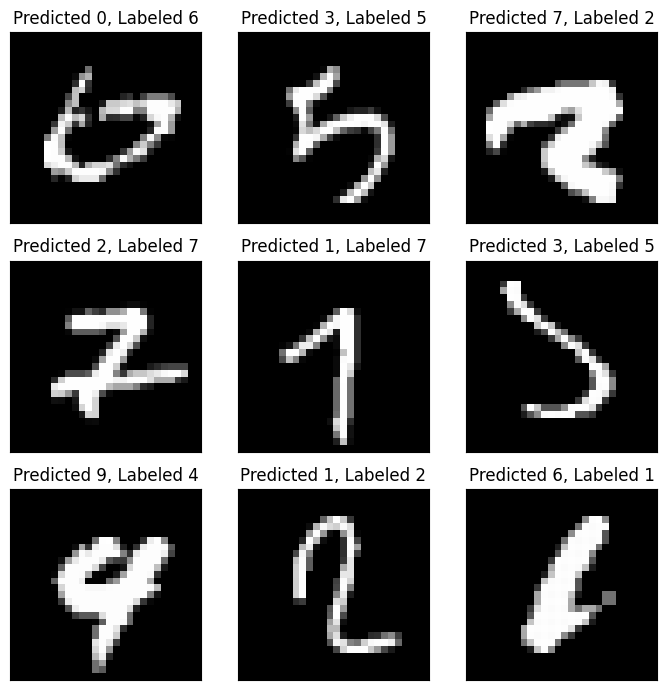

In [31]:
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted,axis=1)
# Check which items we got right / wrong
correct_indices   = np.nonzero(y_predicted == y_test)[0]
incorrect_indices = np.nonzero(y_predicted != y_test)[0]

plt.figure(figsize=(7,7))
for i, incorrect in enumerate(incorrect_indices[np.random.randint(0,len(incorrect_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

## Looking at layers outputs

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

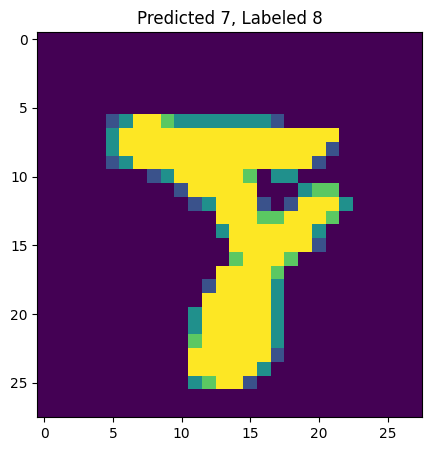

layer:  1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f401b688550>
Shape of conv: (26, 26, 32)


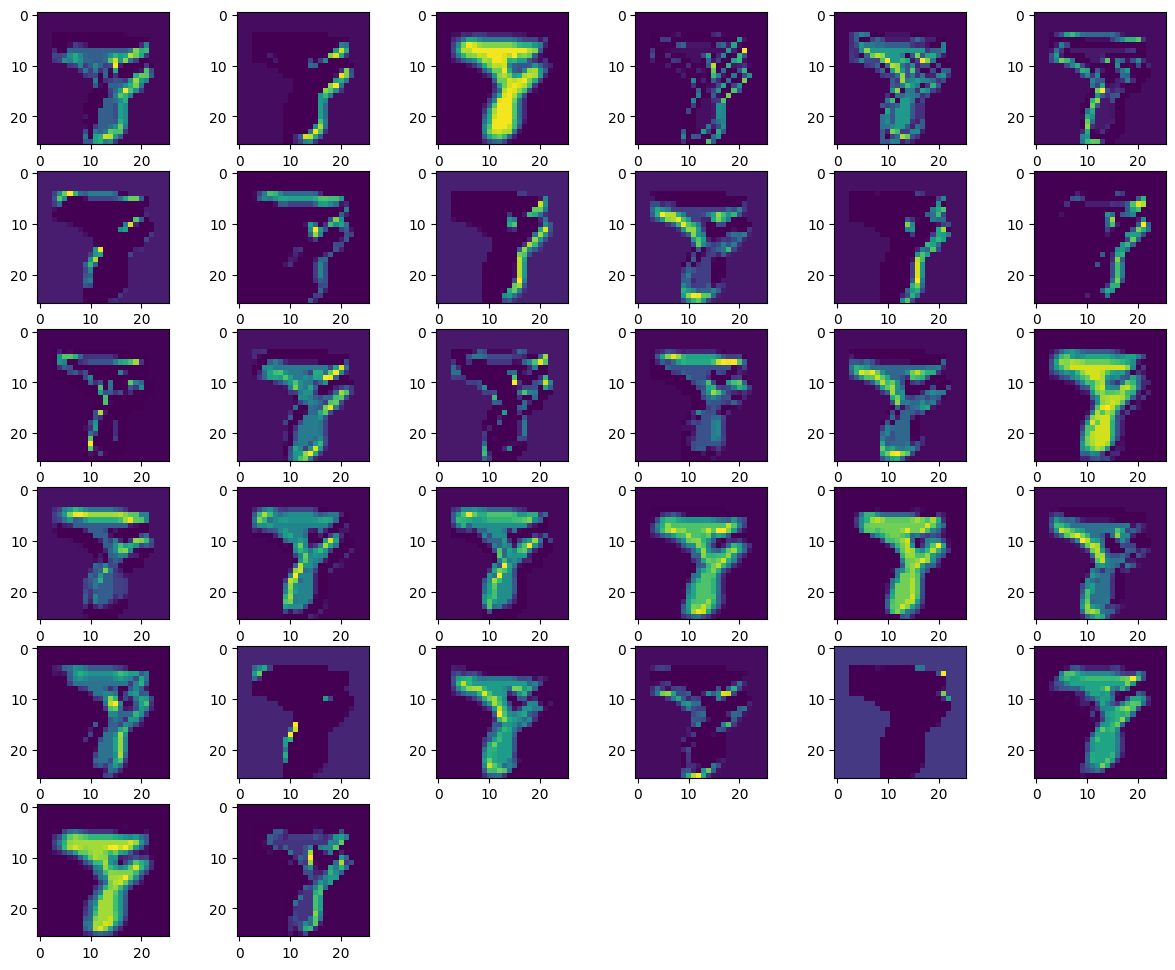

layer:  2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f400d73aa00>
Shape of conv: (24, 24, 32)


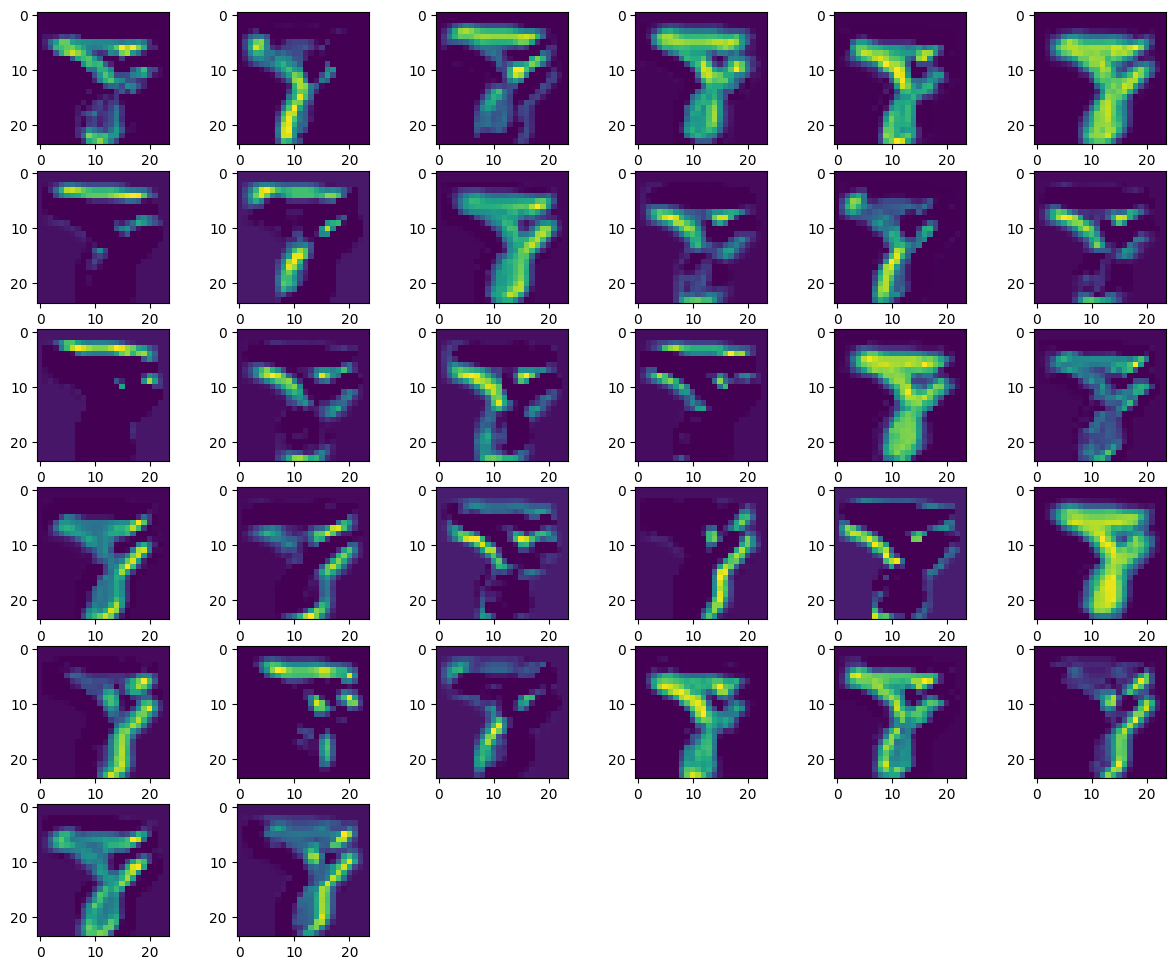

layer:  3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f401bf70640>
Shape of conv: (22, 22, 64)


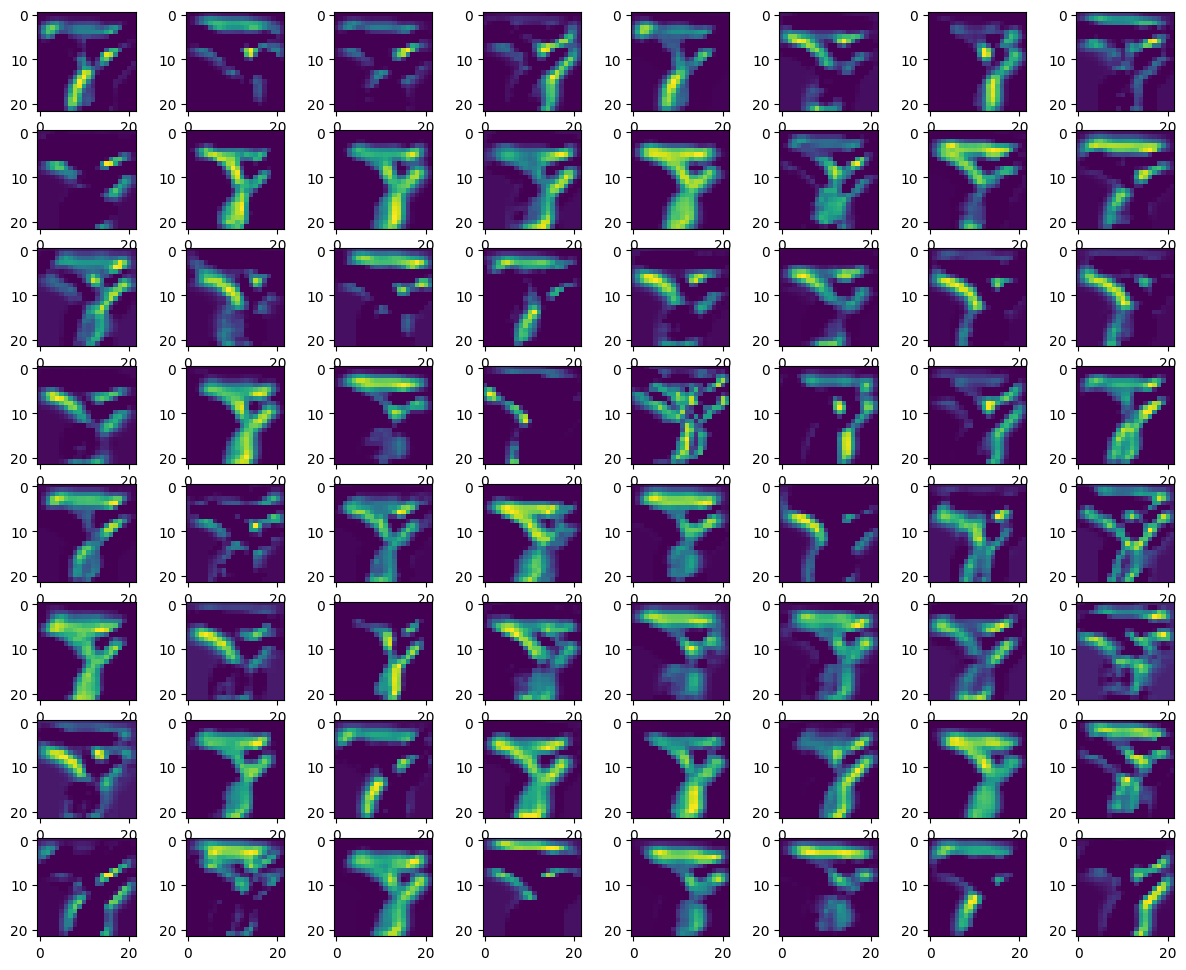

layer:  4 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f401bea28b0>
Shape of conv: (20, 20, 64)


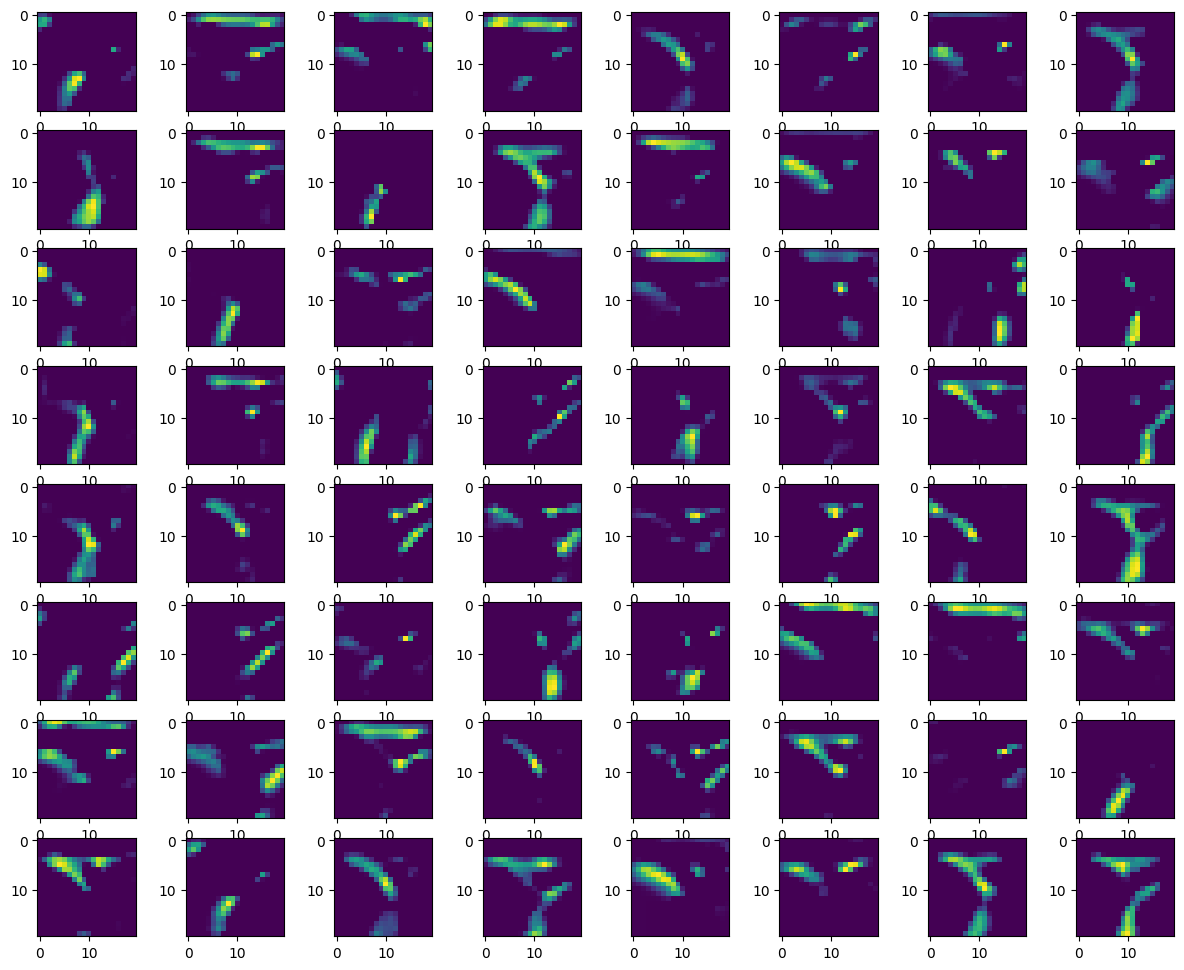

layer:  5 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f401bea4b80>
Shape of conv: (10, 10, 64)


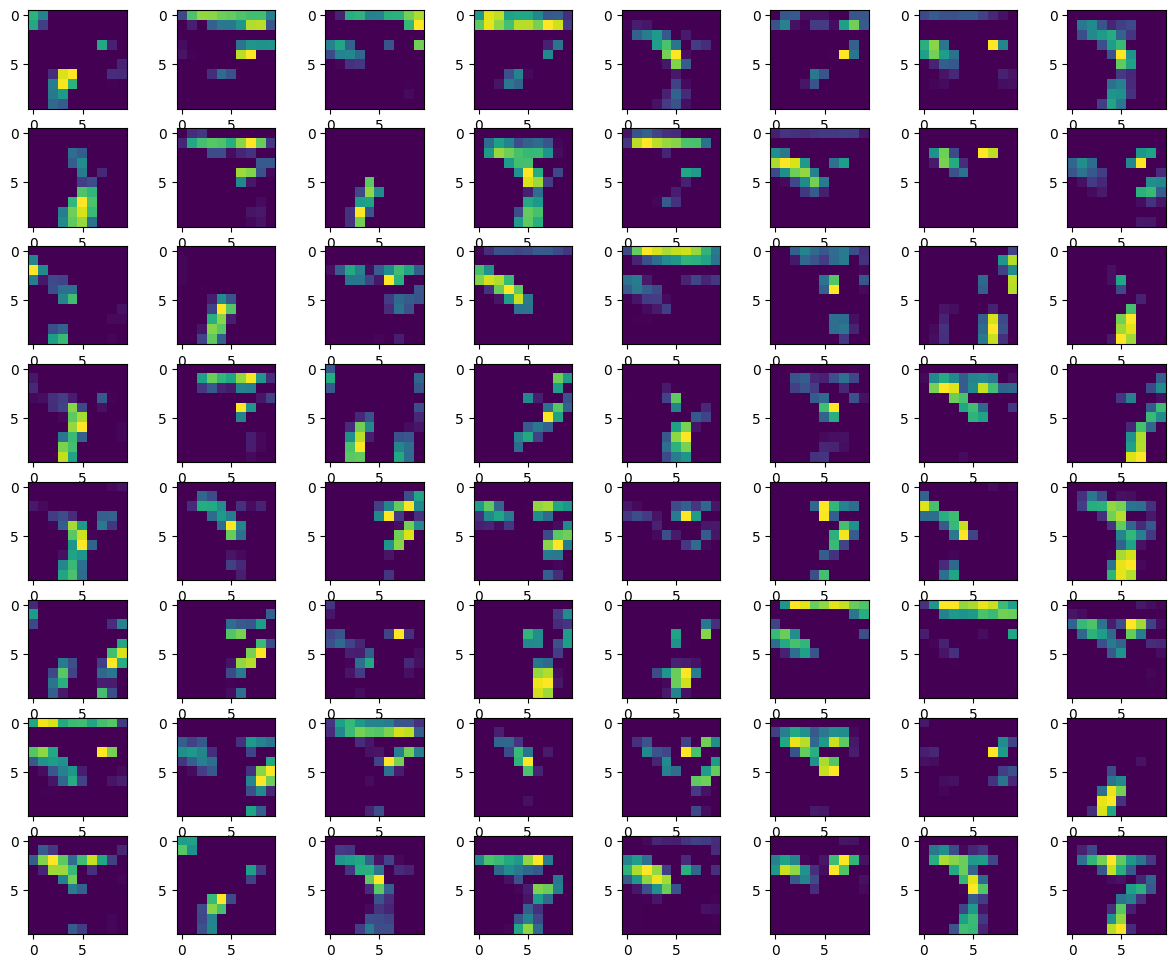

In [32]:
from tensorflow.keras import backend as K

inds = incorrect_indices

num = inds[np.random.randint(0, len(inds))]

img = X_test[num]
img = np.expand_dims(img, axis=0)   # Keras requires the image to be in 4D, so we add an extra dimension to it.

plt.figure()
plt.imshow(img.reshape(28,28), interpolation='none')
plt.title("Predicted {}, Labeled {}".format(y_predicted[num], y_test[num]))
plt.show()

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
    
    _convout1_f = K.function([model.inputs], [layer.output])
    
    convolutions = _convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i])

for i in range(5):
    print('layer: ', i+1 , model.layers[i])
    visualize(model.layers[i]) # visualize layers outputs
    plt.show()    